<a href="https://colab.research.google.com/github/ck1972/Python-Geospatial_Model1/blob/main/Modeling_FCH_GEDI_L2A_S2_Mavuradonha_2022_RF_Model_xML_Scikit_Learn_Final1_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Geospatial Machine Learning for Modeling Forest Canopy Height

## Introduction
### Why Explainable ML (xML)?
*   ML models prioritize accurate predictions but often lack interpretability
*   Most ML models are "black boxes," offering little insight into how predictions are made
*   For example, which predictors influence the model outcome
*   Therefore, xML methods are required so that stakeholders gain insights into the model outcome.
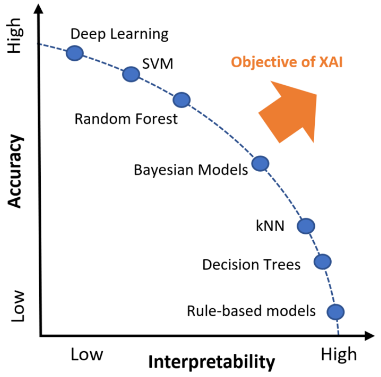
Source: González-Alday et al., 2023

## Lab Tutorial
### Aim
This lab tutorial demonstrates the use of explainable machine learning to model forest canopy height (FCH). We will use the Global Ecosystem Dynamics Investigation (GEDI) Level 2A Geolocated Elevation and Height Metrics Product (GEDI02_A), Sentinel-2 (S2) imagery, canopy chlorophyll content index (CCCI), normalized difference vegetation index (NDVI), and a random forest method.

We will import and display the GEDI02_A points. The points were derived from GEDI Level 2A Geolocated Elevation and Height Metrics Product (GEDI02_A).GEDI is a mission focused on characterizing ecosystem structure and dynamics, enhancing our understanding of Earth's carbon cycle and biodiversity. Attached to the International Space Station (ISS), the GEDI instrument captures global data between latitudes 51.6° N and 51.6° S. It employs three lasers, producing eight beam ground transects that sample approximately every 60 m along-track with a ~25 m footprint resolution.

The GEDI02_A dataset comprises 100 Relative Height (RH) metrics, which collectively describe the waveform collected by GEDI. The original GEDI02_A product is a table of points with a spatial resolution (average footprint) of 25 meters. You can get more information at https://lpdaac.usgs.gov/documents/986/GEDI02_UserGuide_V2.pd

Following are the steps to model FCH.

## Install Libraries
Install all the necessary libraries.

In [ ]:
# Install some packages
!pip install rasterio # designed for reading and manipulating raster data, which includes images from satellites or aerial sensors.
!pip install earthpy # is a helper library built to simplify common workflows in Earth data science (file management, data processing, plotting and visualization, and analysis functions)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.1 MB/s eta 0:00:00


In [ ]:
# Import the libraries
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import rasterize
import pandas as pd
import earthpy.plot as ep
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from google.colab import drive

## Setting-up Colab
### Mount your Google Drive
First, mount your Google Drive using the code below. Import the raster  and vector datasets and prepare the features and labels.

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define variables
Set the access path to both the vector and image datasets. Then define the response and predictor variables.

In [ ]:
# Define path to datasets
SAMPLE_PATH = '/content/drive/My Drive/Mavuradonha_Datasets/SampleFCH.csv'
IMAGE_PATH = '/content/drive/My Drive/Mavuradonha_Datasets/prs_S2_Indices_2021.tif'
SHP_PATH = '/content/drive/My Drive/Mavuradonha_Datasets/Mav_Subset_Boundary.shp'

# Define varaibales
Predictors = ['B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'CCCI', 'NDVI'] # Sentinel-2
Response = ['rh98'] # GEDI forest conopy height

## Create image composites
Load and display the imagery.

Number of bands: 10
Image dimensions (Height x Width): 1814 x 4442
Coordinate Reference System: EPSG:32736


/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


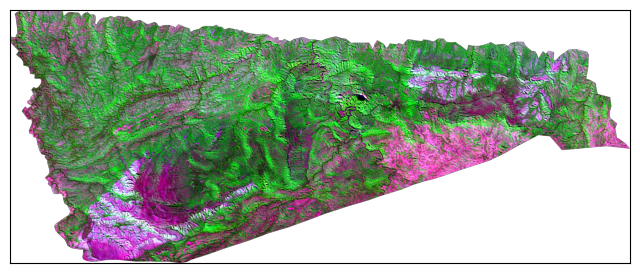

<Axes: >

In [ ]:
# Load the image
image = rasterio.open(IMAGE_PATH)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

# Display image properties
print(f"Number of bands: {bandNum}")
print(f"Image dimensions (Height x Width): {height} x {width}")
print(f"Coordinate Reference System: {crs}")

image_vis = []
for x in [8, 6, 2]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

# Prepare datasets for modeling
## Import the sample data

Next, we are going to load the sample data with the canopy height (CH) and raster variables.

In [ ]:
# Read sample
samples = pd.read_csv(SAMPLE_PATH)[Predictors + Response]
samples

,B3,B4,B5,B6,B7,B8,B11,B12,CCCI,NDVI,rh98
0,0.282843,0.331361,0.387556,0.441928,0.467333,0.486621,0.542679,0.466154,0.611886,0.683208,2.940000
1,0.197231,0.219545,0.318041,0.372022,0.393764,0.369121,0.423261,0.326879,0.573926,0.738683,3.060000
2,0.252883,0.277399,0.352420,0.430174,0.459347,0.481508,0.518507,0.412492,0.651173,0.750810,3.140000
3,0.253180,0.205548,0.316307,0.483011,0.526118,0.570438,0.482545,0.354471,0.764837,0.885081,3.180000
4,0.262298,0.301662,0.382361,0.445533,0.467654,0.476025,0.507445,0.416893,0.607833,0.713476,3.320000
...,...,...,...,...,...,...,...,...,...,...,...
610,0.268608,0.235160,0.325576,0.488723,0.522924,0.577624,0.447940,0.316386,0.758899,0.857822,29.660000
611,0.251197,0.203470,0.296479,0.532541,0.580345,0.634665,0.435660,0.291890,0.820868,0.906799,30.010000
612,0.250599,0.260192,0.353553,0.484045,0.524500,0.539815,0.485592,0.355809,0.699808,0.811473,31.090000
613,0.234947,0.244540,0.314325,0.437035,0.482390,0.484871,0.451553,0.343366,0.704103,0.797219,31.200001


## Split training data
First, let's split the training points into training and test datasets.

In [ ]:
# Split into train and test
train, test = train_test_split(samples, test_size=0.2, shuffle=True, random_state=42)

# Get varibles input and output
X_train = train[Predictors].to_numpy()
X_test = test[Predictors].to_numpy()
y_train = train[Response].to_numpy().astype(float)
y_test = test[Response].to_numpy().astype(float)

# Show the data shape
print(f'Train features: {X_train.shape}\nTest features: {X_test.shape}\nTrain label: {y_train.shape}\nTest label: {y_test.shape}')

Train features: (492, 10)
Test features: (123, 10)
Train label: (492, 1)
Test label: (123, 1)


Check for missing or NAs values.

In [ ]:
# Check for NaN or missing values in X_train, X_test, y_train, y_test
def check_for_missing_values(array, array_name):
    nan_count = np.isnan(array).sum()
    if nan_count > 0:
        print(f"{array_name} contains {nan_count} missing values (NaNs).")
    else:
        print(f"{array_name} does not contain any missing values.")

# Check X_train, X_test, y_train, y_test for missing values
check_for_missing_values(X_train, 'X_train')
check_for_missing_values(X_test, 'X_test')
check_for_missing_values(y_train, 'y_train')
check_for_missing_values(y_test, 'y_test')

X_train does not contain any missing values.
X_test does not contain any missing values.
y_train does not contain any missing values.
y_test does not contain any missing values.


## Perform exploratory data analysis (EDA)
Exploratory data analysis (EDA) is an important step in understanding your data before building a machine learning model. To perform EDA on your training dataset, we will use libraries such as pandas for data manipulation and matplotlib or seaborn for data visualization. First, we will start by creating a DataFrame for the training dataset.

In [ ]:
# Create a DataFrame from X_train and y_train
train_df = pd.DataFrame(data=np.c_[X_train, y_train], columns=[f'Band_{i}' for i in range(X_train.shape[1])] + ['FCH'])

# Rename columns in the DataFrame train_df
train_df.columns = Predictors + ['FCH']

We will take a quick look at the top five rows using the DataFrame's head() method.

In [ ]:
# Check the first five rows
train_df.head()

,B3,B4,B5,B6,B7,B8,B11,B12,CCCI,NDVI,FCH
0,0.229565,0.193391,0.304959,0.455412,0.488057,0.507445,0.436348,0.316860,0.734665,0.873177,6.500000
1,0.220227,0.172627,0.279285,0.486929,0.539444,0.552811,0.387814,0.250599,0.796663,0.911151,6.660000
2,0.174642,0.131909,0.230217,0.448442,0.500700,0.510882,0.367287,0.239583,0.831210,0.937500,9.000000
3,0.262107,0.264197,0.324500,0.482390,0.521153,0.529623,0.446542,0.328938,0.727061,0.800742,17.030001
4,0.235584,0.227816,0.317490,0.465618,0.506656,0.509510,0.426966,0.311769,0.720311,0.833387,10.590000


Let's use the info() method to get a quick description of the data.

In [ ]:
# Use the info()to check the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   B3      492 non-null    float64
 1   B4      492 non-null    float64
 2   B5      492 non-null    float64
 3   B6      492 non-null    float64
 4   B7      492 non-null    float64
 5   B8      492 non-null    float64
 6   B11     492 non-null    float64
 7   B12     492 non-null    float64
 8   CCCI    492 non-null    float64
 9   NDVI    492 non-null    float64
 10  FCH     492 non-null    float64
dtypes: float64(11)
memory usage: 42.4 KB


Next, we will use the describe() method to get summary statistics of the training dataset. This will provide statistics such as mean, standard deviation, minimum, maximum, and quartiles for each feature and the target variable.

In [ ]:
# Prepare summary statistics
summary_stats = train_df.describe()
print(summary_stats)

               B3          B4          B5          B6          B7          B8  \
count  492.000000  492.000000  492.000000  492.000000  492.000000  492.000000   
mean     0.234947    0.223586    0.316738    0.461710    0.502460    0.514284   
std      0.027145    0.049701    0.039501    0.034957    0.039644    0.042785   
min      0.141774    0.119164    0.216564    0.340000    0.369053    0.309354   
25%      0.217600    0.189473    0.291526    0.438620    0.476524    0.488006   
50%      0.231840    0.214243    0.307571    0.460081    0.501747    0.512445   
75%      0.248420    0.247285    0.333804    0.482416    0.526023    0.538540   
max      0.381576    0.410366    0.510392    0.598415    0.646645    0.656277   

              B11         B12        CCCI        NDVI         FCH  
count  492.000000  492.000000  492.000000  492.000000  492.000000  
mean     0.440439    0.321525    0.723968    0.837877   11.688618  
std      0.041069    0.046636    0.048614    0.060590    5.427908 

Next, create box and density plot for the canopy height.

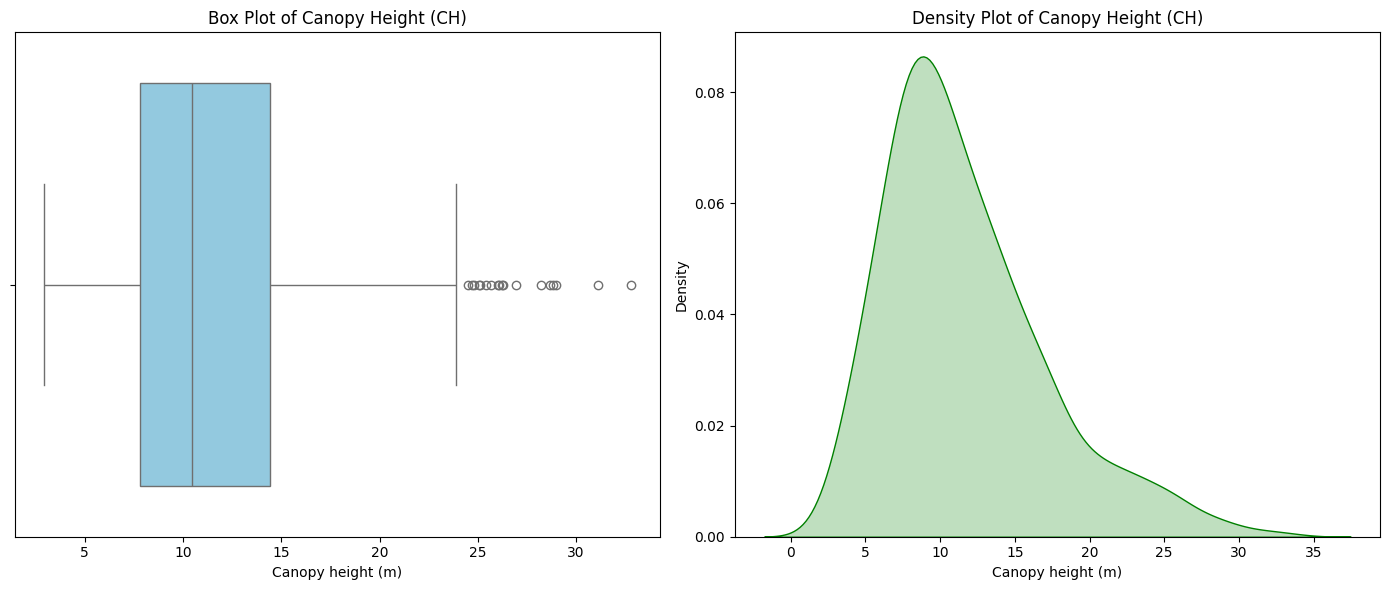

In [ ]:
# Set up the figure and axes for box and density plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box plot for 'CH'
sns.boxplot(data=train_df, x='FCH', ax=axes[0], color="skyblue")
axes[0].set_title('Box Plot of Canopy Height (CH)')
axes[0].set_xlabel('Canopy height (m)')

# Density plot for 'CH'
sns.kdeplot(data=train_df, x='FCH', ax=axes[1], fill=True, color="green")
axes[1].set_title('Density Plot of Canopy Height (CH)')
axes[1].set_xlabel('Canopy height (m)')

# Adjust layout
plt.tight_layout()
plt.show()

Let's generate a bar plot to show mean spectral reflectance for each band.

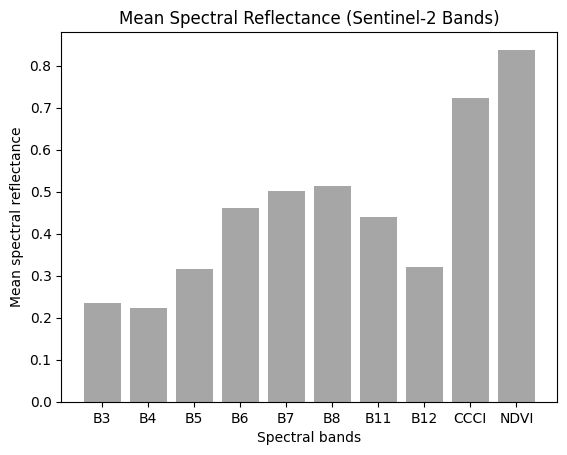

In [ ]:
# Calculate mean reflectance for each band
mean_reflectance = [train_df[band].mean() for band in Predictors]

# Plot the mean reflectance for each band
plt.bar(Predictors, mean_reflectance, color='grey', alpha=0.7)

# Add labels and title
plt.xlabel('Spectral bands')
plt.ylabel('Mean spectral reflectance')
plt.title('Mean Spectral Reflectance (Sentinel-2 Bands)')

# Show the plot
plt.show()

We will visualize the distribution and potential outliers of each feature using boxplots. This code will generate a boxplot for each feature, showing the median, quartiles, and any potential outliers.

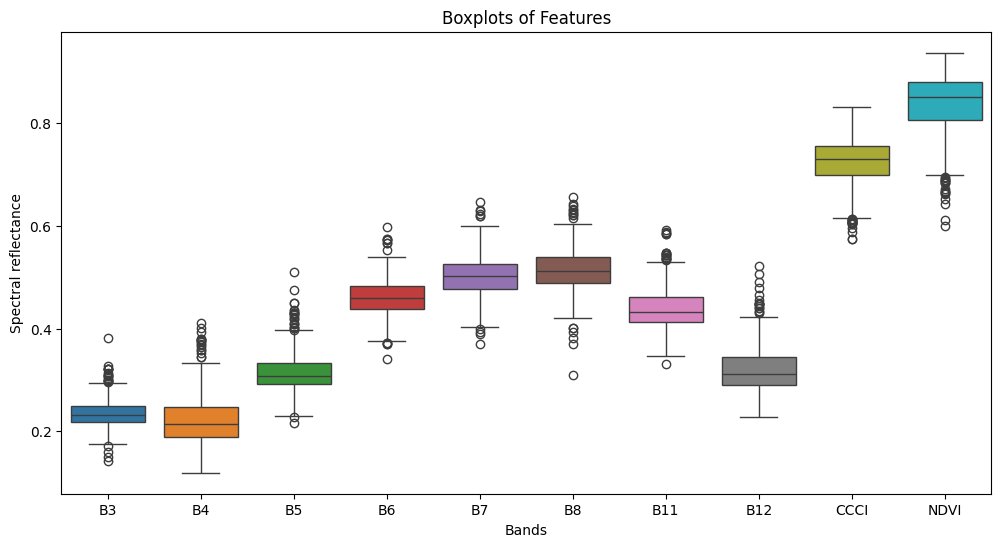

In [ ]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Create boxplots for each feature
sns.boxplot(data=train_df.drop(columns=['FCH']), orient='v')
plt.title('Boxplots of Features')
plt.xlabel('Bands')
plt.ylabel('Spectral reflectance')
plt.show()

We will also visualize the distribution of each feature and the target variable using density plots (also known as kernel density plots).

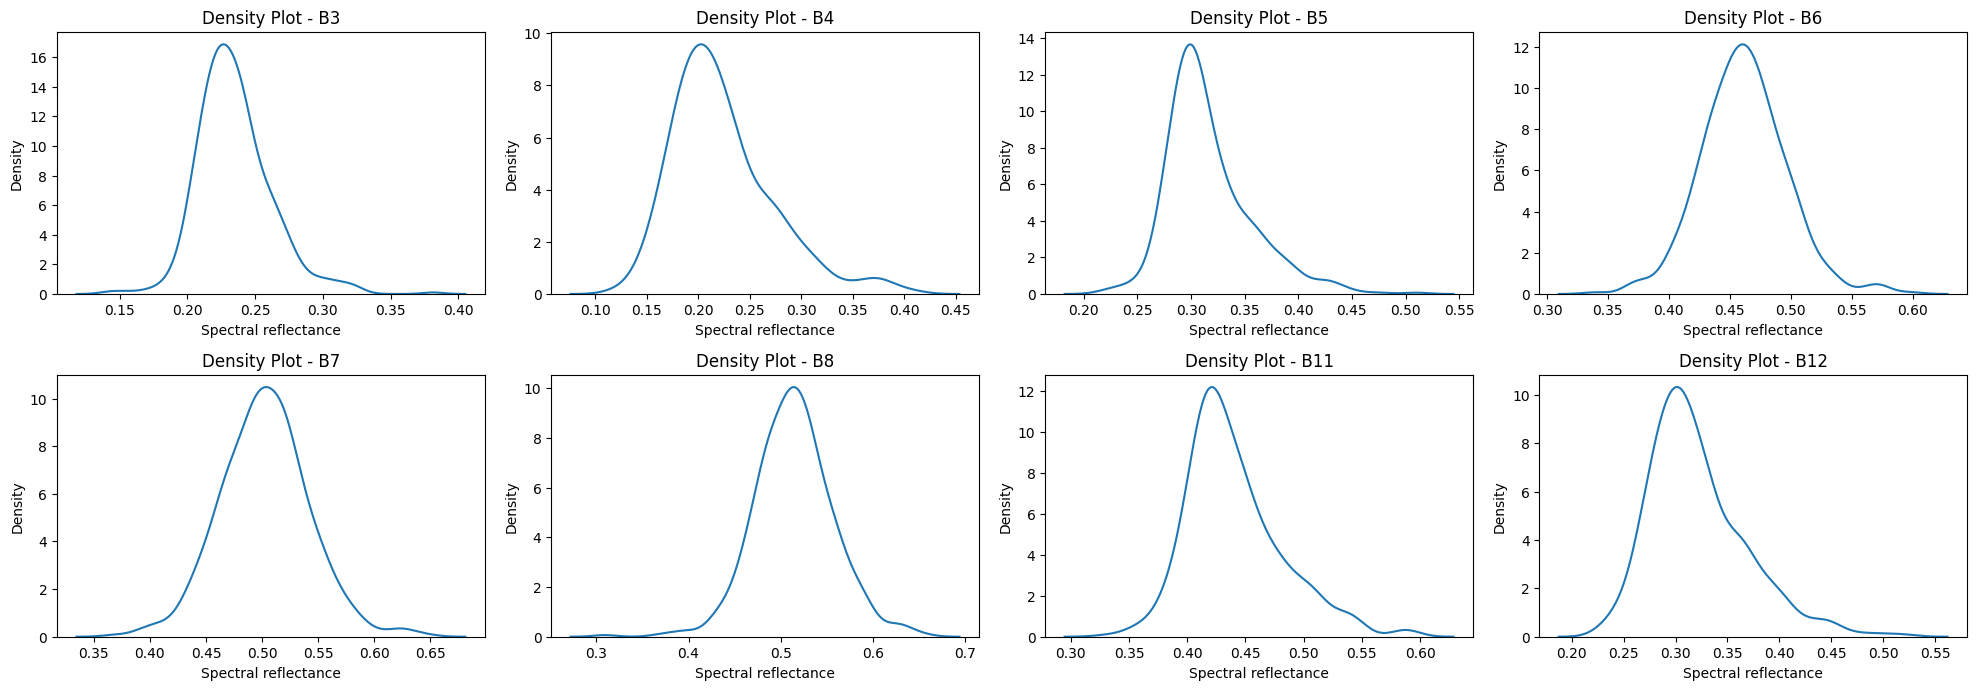

In [ ]:
# Determine the number of rows and columns in the subplot grid
num_bands = len(train_df.columns) - 1  # Exclude the last column (FCH)
num_rows = int(np.ceil(num_bands / 4))  # Adjust the number of columns as needed
num_cols = 4  # Set the number of columns per row

# Set the figure size based on the number of subplots
plt.figure(figsize=(20, 10))

# Iterate through the feature columns (bands) and create density plots
for i, col in enumerate(train_df.columns[:-1]):  # Exclude the last column (AGBD)
    plt.subplot(num_rows, num_cols, i + 1)
    sns.kdeplot(train_df[col], label=col)
    plt.title(f'Density Plot - {col}')
    plt.xlabel('Spectral reflectance')
    plt.ylabel('Density')

# Remove empty subplots (if any)
for i in range(num_bands, num_rows * num_cols):
    plt.delaxes(plt.gca())

plt.tight_layout()
plt.show()

## Select and Train a Model Training
### Train random forest (RF) model
We will use the random forest, which was introduced in Scikit-learn 0.21.

In [ ]:
# Set a random seed for reproducibility
np.random.seed(42)

# Create and fit the Random Forest model
rf_reg = RandomForestRegressor()
rf_model = rf_reg.fit(X_train, y_train.ravel())

Next, we will use K-fold cross validation feature to split the training data into 10 subsets called folds.

In [ ]:
# Calculate the RMSE for the Random Forest regression model
scores = cross_val_score(rf_reg, X_train, y_train.ravel(),
                         scoring="neg_mean_squared_error", cv=10)

Finally, let's check the rmse score for the RF regression model.

In [ ]:
# Check the RMSE scores
rf_reg_rmse_scores = np.sqrt(-scores)
print(rf_reg_rmse_scores)

[5.52118926 5.63214691 5.64185247 6.00695751 5.07422127 5.3968792
 5.00701595 5.00589113 5.44117958 5.95023477]


Finally, let's plot a graph showing the performance of random forest regression model.

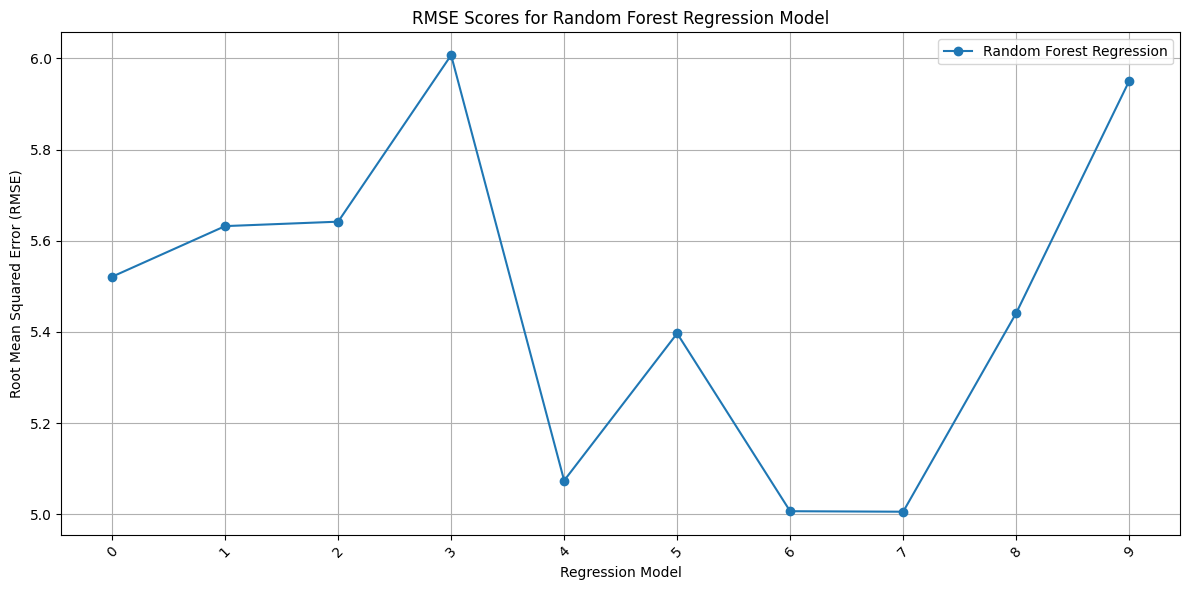

In [ ]:
# Labels for the models
model_labels = ['Random Forest Regression']

# Create a line graph for RMSE scores
plt.figure(figsize=(12, 6))

# Model indices (x-values)
x_values = range(len(rf_reg_rmse_scores))

# Plot RMSE scores for each model
plt.plot(x_values, rf_reg_rmse_scores, marker='o', label='Random Forest Regression')

# Customize the plot
plt.xticks(x_values, x_values, rotation=45)  # Set tick locations to match the length of the data
plt.xlabel('Regression Model')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('RMSE Scores for Random Forest Regression Model')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

Predict using the test data and create a scatter plot.

Mean Bias Error (MBE): -0.35825766374376766
Root Mean Square Error (RMSE): 6.847673998266263
R-squared (R2): -0.06800056507552399


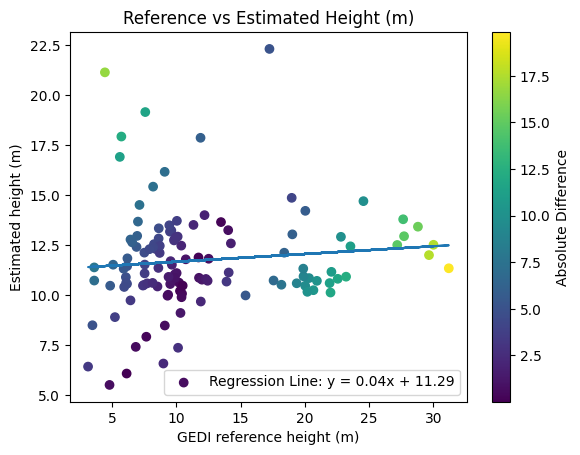

In [ ]:
# Predict test data
rf_prediction = rf_model.predict(X_test).flatten()
label = y_test.flatten()

# Calculate MBE
mbe = np.mean(rf_prediction - label)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(label, rf_prediction))

# Calculate R2
r2 = r2_score(label, rf_prediction)

print(f'Mean Bias Error (MBE): {mbe}')
print(f'Root Mean Square Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

# Calculate the absolute difference between predicted and actual values
absolute_diff = np.abs(rf_prediction - label)

# Plot the scatter plot with colors based on the absolute difference
plt.scatter(label, rf_prediction, c=absolute_diff, cmap='viridis')
m, b = np.polyfit(label, rf_prediction, 1)
plt.plot(label, m*label + b)
plt.title('Reference vs Estimated Height (m)')
plt.xlabel('GEDI reference height (m)')
plt.ylabel('Estimated height (m)')
plt.colorbar(label='Absolute Difference')  # Adding a colorbar for reference
plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(m, b)])

plt.show()

We will also plot the training and validation learning curves for the RF model.

## Predict and display RF FCH map
Next, we will predict and display the FCH map derived from the RF model.

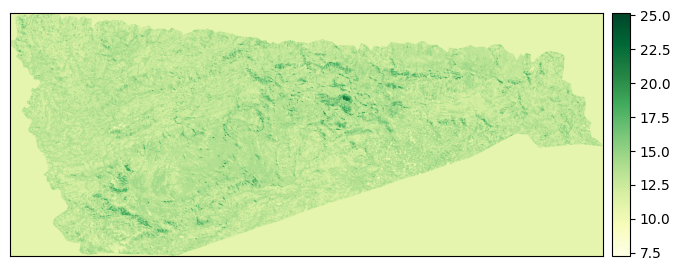

<Axes: >

In [ ]:
# Predict image using the model
image_input = []
for x in range(10):
  image_input.append(image.read(x + 1))
image_input = np.stack(image_input).reshape(10, -1).T

# Predict
rf_prediction = rf_model.predict(image_input)
rf_prediction = rf_prediction.reshape(shape[0], shape[1])

# Visualize
ep.plot_bands(rf_prediction, cmap='YlGn', figsize=plot_size)

Save the FCH map.

In [ ]:
# Save file to drive
save_location = '/content/drive/My Drive/Mavuradonha_Datasets/'
name = 'RF_Model2_FCH21.tif'
location = save_location + name

new_dataset = rasterio.open(
      location,
      mode='w', driver='GTiff',
      height = rf_prediction.shape[0], width = rf_prediction.shape[1],
      count=1, dtype=str(rf_prediction.dtype),
      crs=crs,
      transform=transform
)
new_dataset.write(rf_prediction, 1);
new_dataset.close()

# Perform Explainable Machine Learning (xML)
 We will use SHAP (SHapley Additive exPlanations), a popular explainable machine learning (xML) method. SHAP is based on Shapley values, a concept from cooperative game theory introduced by Lloyd Shapley in 1953, which has been adapted for interpreting machine learning models. In XML, Shapley values provide a way to quantify each feature's contribution to a prediction by calculating its average marginal contribution across all possible subsets of features. In other words, Shapley values fairly distribute the "credit" for a prediction among different features, offering a comprehensive view of feature importance within machine learning models.

Reference
Shapley LS (1953) A value for n-person games. In: Contributions to the Theory of Games 2.28, pp. 307–317.

### Import SHAP
First, let's import the shap library.

In [ ]:
# Import the shap library.
import shap

## Explainable ML for the random forest model
### Create an explainer
Let's create the explainer, which computes the SHAP (SHapley Additive exPlanations) values. for the RF model. Keep in mind that SHAP explanations are approximations and might not perfectly capture the full complexity of RF model. However, they can be very useful for gaining insights into understanding feature contributions.


Note that it takes times to run the SHAP using RF model. You can use 'shap.sample()' to create a summarized background dataset to speed up the computation of SHAP values.

In [ ]:
# Create the SHAP explainer using the trained model
explainer_rf = shap.Explainer(rf_model.predict, X_train)

# Compute SHAP values for the training set
shap_values_rf = explainer_rf(X_train)

ExactExplainer explainer: 493it [05:48,  1.40it/s]


#### Verify the SHAP values object
Let's check the type and attributes of shap_values_rf
 to ensure it was created correctly.

In [ ]:
print(type(shap_values_rf))
print(shap_values_rf.shape)
print(dir(shap_values_rf))

<class 'shap._explanation.Explanation'>
(492, 10)
['__add__', '__class__', '__copy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__radd__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rsub__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__weakref__', '_apply_binary_operator', '_flatten_feature_names', '_numpy_func', '_s', '_use_data_as_feature_names', 'abs', 'argsort', 'base_values', 'clustering', 'cohorts', 'compute_time', 'data', 'display_data', 'error_std', 'feature_names', 'flip', 'hclust', 'hierarchical_values', 'hstack', 'identity', 'instance_names', 'lower_bounds', 'main_effects', 'max', 'mean', 'min', 'op_history', 'output_dims', 'output_indexes', 'output_names', 'percentile', 'sample', 'shape', 'sum', 'upper_bounds'

### Interpreting global feature importance
#### Global bar plot
We will use SHAP to generate global feature importance, showing which features are most important across all predictions. Passing a matrix of SHAP values to the bar plot function creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

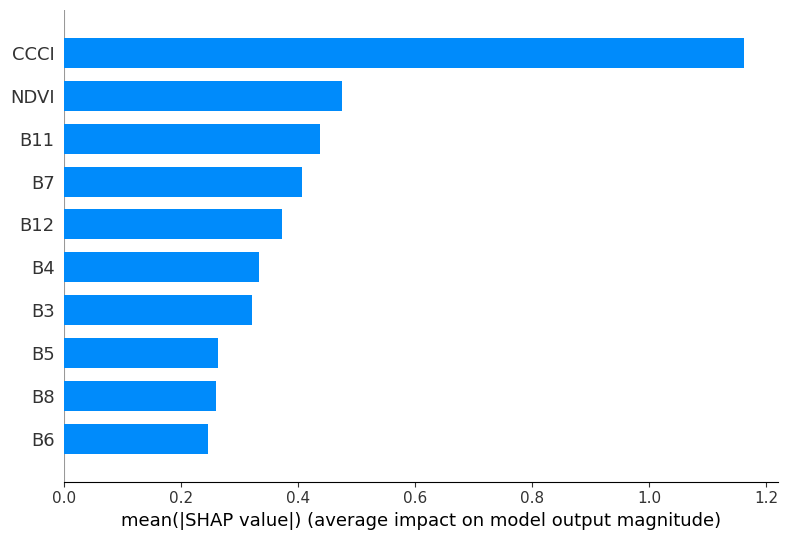

In [ ]:
# Summarize the SHAP values with a bar plot and include the band names
shap.summary_plot(shap_values_rf, X_train, plot_type='bar', feature_names=Predictors)
plt.show()

Note that the SHAP (SHapley Additive exPlanations)  bar plot only shows the magnitude of the contribution of each predictor variable (band). How, it does not show the direction (negative or positive) of each predictor variable to the model.

Next, we will use the the shap.summary_plot() function to generate a summary plot of SHAP values using a beeswarm (or dot) plot. The beeswarm plot helps in comparing the impact of different features on model predictions. Each dot on the plot represents a feature, and its position along the axis represents the magnitude and direction of its impact on individual predictions. In addition, it is useful for visualizing the distribution of SHAP values for each feature. The plot's vertical positioning of dots shows the range and density of SHAP values across the dataset for each specific feature.

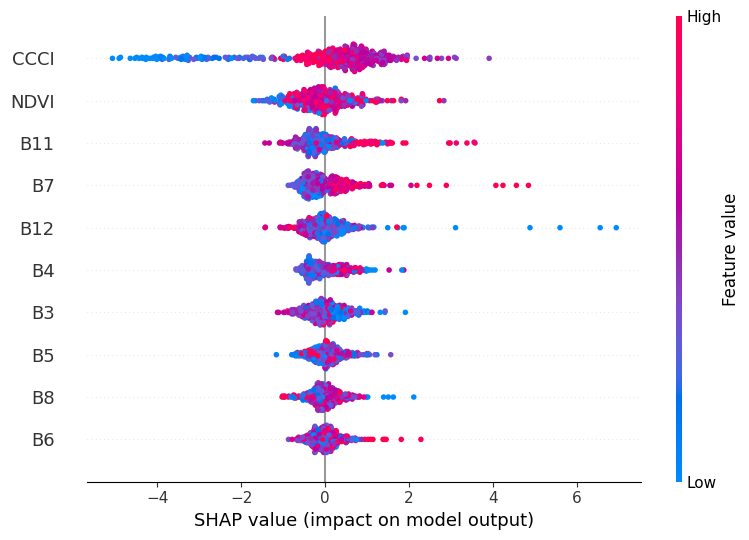

In [ ]:
# Summarize the SHAP values with a bar plot and include the band names
shap.summary_plot(shap_values_rf, X_train, plot_type='dot', feature_names=Predictors)
plt.show()

### Simple dependence scatter plot
Next, create depende plots for all the variables. A dependence scatter plot illustrates the effect of a single feature on a model's predictions, with each dot representing a single prediction from the dataset. In this example, the probability of predicting canopy height increases significantly when the spectral reflectance ranges from 0.2 to 0.26. The x-axis displays the feature's value (from the X matrix stored in explanation.data), while the y-axis shows the SHAP value for that feature (stored in explanation.values), indicating how much knowing that feature's value changes the model's output for each prediction. A light grey histogram at the bottom of the plot depicts the distribution of data values.

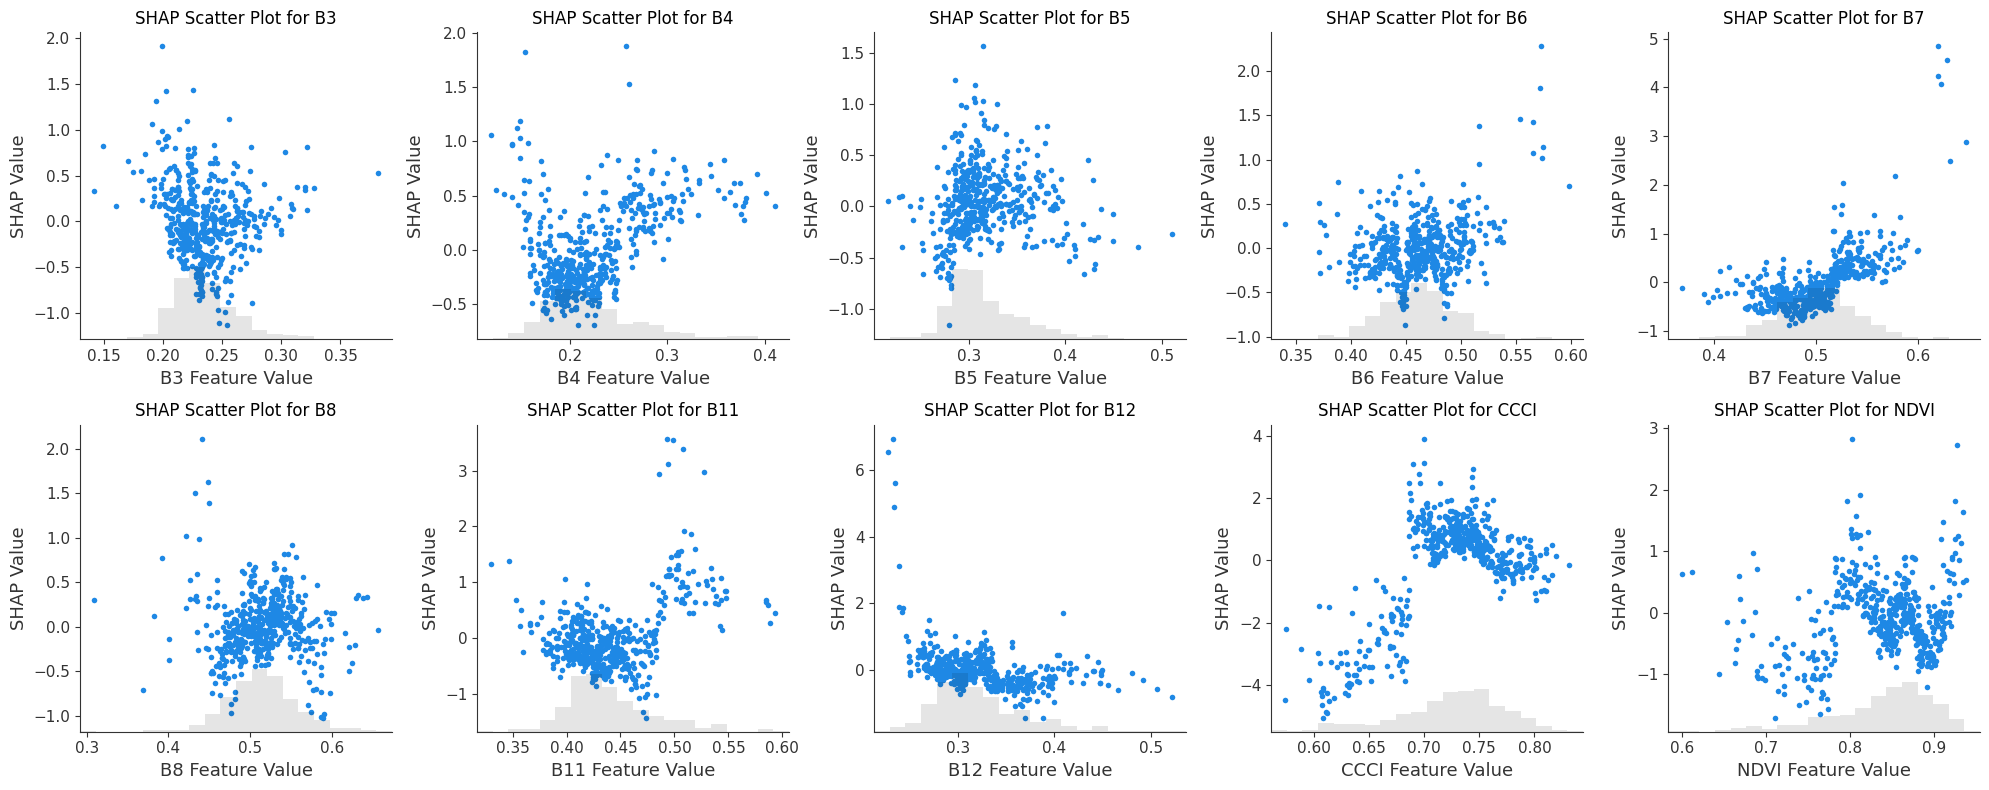

In [ ]:
# Assign feature names to the SHAP values object
shap_values_rf.feature_names = Predictors

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop over each predictor and create a scatter plot in the corresponding subplot
for idx, predictor in enumerate(Predictors):
    shap.plots.scatter(shap_values_rf[:, predictor], ax=axes[idx], show=False)
    axes[idx].set_title(f'SHAP Scatter Plot for {predictor}')
    axes[idx].set_xlabel(f'{predictor} Feature Value')
    axes[idx].set_ylabel('SHAP Value')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

### Compute SHAP maps
Computing a SHAP maps for each predictor variable for this study area will take about 20 hours. Therefore, we will create a spatial subset of the study area using a shapefile to focus on a smaller region. This aproach reduces the computational load and allows you to compute SHAP values for all pixels within that subset. Below, is procedure to compute SHAP maps for the selected predictors:

1. Reading the boundary shapefile and predictors.
2. Masking the predictors using the shapefile to extract the subset.
3. Preparing the subset data for SHAP value computation.
4. Computing SHAP values for all pixels within the subset.
5. Mapping SHAP values back to spatial dimensions and visualizing the results.

#### Load the boundary and predictor variables
First, we will Load the boundary and predictor variables.

In [ ]:
# Path to the shapefile
SHP_PATH = '/content/drive/My Drive/Mavuradonha_Datasets/Mav_Subset_Boundary.shp'

# Read the shapefile using geopandas
subset_boundary = gpd.read_file(SHP_PATH)

# Print the CRS of the shapefile
print(f"Shapefile CRS: {subset_boundary.crs}")


Shapefile CRS: EPSG:32736


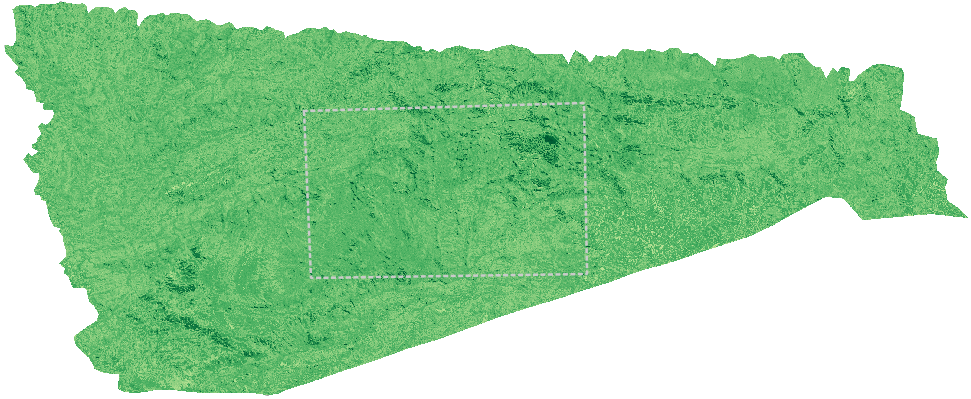

#### Masking the predictors
Next, we will mask the predictors using the shapefile to extract the subset.

In [ ]:
from rasterio.mask import mask
# Open the raster data
image = rasterio.open(IMAGE_PATH)

# Print the CRS of the raster data
print(f"Raster CRS: {image.crs}")

# Reproject shapefile to match raster CRS if necessary
if subset_boundary.crs != image.crs:
    subset_boundary = subset_boundary.to_crs(image.crs)
    print("Reprojected shapefile to match raster CRS.")

# Convert the shapefile geometry to GeoJSON format
geometries = [feature["geometry"] for feature in subset_boundary.__geo_interface__["features"]]

# Mask the raster data using the shapefile geometry
out_image, out_transform = mask(dataset=image, shapes=geometries, crop=True)

# Update the metadata
out_meta = image.meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Close the original image
image.close()


Raster CRS: EPSG:32736


#### Prepare the subset data
Next, we will prepare the subset data for SHAP value computation.

In [ ]:
# Get the number of bands, height, and width from the masked image
bands, height, width = out_image.shape
num_pixels = height * width

print(f"Subset image dimensions (Height x Width): {height} x {width}")
print(f"Number of bands: {bands}")
print(f"Total number of pixels in subset: {num_pixels}")

# Reshape image data to have pixels as rows and bands as columns
X_all = out_image.reshape(bands, num_pixels).T  # Shape: (num_pixels, num_features)

# Handle NoData values
valid_mask = ~np.isnan(X_all).any(axis=1)
X_valid = X_all[valid_mask]  # Only valid pixels
num_valid_pixels = X_valid.shape[0]

print(f"Number of valid pixels in subset: {num_valid_pixels}")

Subset image dimensions (Height x Width): 808 x 1306
Number of bands: 10
Total number of pixels in subset: 1055248
Number of valid pixels in subset: 1055248


Compute SHAP values.
Next, we will compute SHAP values for all pixels within the subset.


In [ ]:
from tqdm import tqdm

# Feature names (adjust according to your actual features)
all_feature_names = ['B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'CCCI', 'NDVI']

# Predictors for SHAP maps
Predictors = ['CCCI', 'B7', 'B8', 'NDVI']
num_predictors = len(Predictors)

# Get indices of the Predictors in all_feature_names
feature_indices = [all_feature_names.index(feature) for feature in Predictors]

# Initialize the SHAP explainer using TreeExplainer
explainer = shap.TreeExplainer(rf_model)

# Adjust batch processing
batch_size = 10000  # Adjust based on your system's memory capacity
num_batches = int(np.ceil(num_valid_pixels / batch_size))

print(f"Computing SHAP values in {num_batches} batches")

# Initialize SHAP values array
shap_values_array = np.zeros((num_valid_pixels, num_predictors), dtype=np.float32)

# Prepare batch indices
batch_indices = [(i * batch_size, min((i + 1) * batch_size, num_valid_pixels)) for i in range(num_batches)]

# Compute SHAP values with a progress bar
for start_idx, end_idx in tqdm(batch_indices, desc="Computing SHAP values"):
    X_batch = X_valid[start_idx:end_idx]
    shap_values_batch = explainer.shap_values(X_batch)

    # For regression models, shap_values_batch is an array of shape (n_samples, n_features)
    # Extract SHAP values for the specified predictors
    shap_values_subset = shap_values_batch[:, feature_indices]

    # Store the SHAP values
    shap_values_array[start_idx:end_idx, :] = shap_values_subset

# Map SHAP values back to spatial dimensions
shap_maps = {}
for idx, predictor_name in enumerate(Predictors):
    # Initialize full map with NaNs
    shap_map_full = np.full(num_pixels, np.nan, dtype=np.float32)
    # Get the indices of the valid pixels in the original subset image
    valid_pixel_indices = np.where(valid_mask)[0]
    # Assign the SHAP values to the correct positions
    shap_map_full[valid_pixel_indices] = shap_values_array[:, idx]
    # Reshape to spatial dimensions
    shap_maps[predictor_name] = shap_map_full.reshape((height, width))
# Check the range of SHAP values
for predictor_name in Predictors:
    shap_map = shap_maps[predictor_name]
    valid_shap_values = shap_map[~np.isnan(shap_map)]
    if valid_shap_values.size > 0:
        print(f"Predictor: {predictor_name}, SHAP values range: {valid_shap_values.min()} to {valid_shap_values.max()}")
    else:
        print(f"Predictor: {predictor_name}, SHAP map contains no valid values.")

# Define vmin and vmax based on SHAP values
max_abs_shap = max([np.nanmax(np.abs(shap_maps[predictor])) for predictor in Predictors])
vmin = -max_abs_shap
vmax = max_abs_shap

#### Map SHAP values
Finally, we will map the SHAP values back to spatial dimensions and visualize the results.

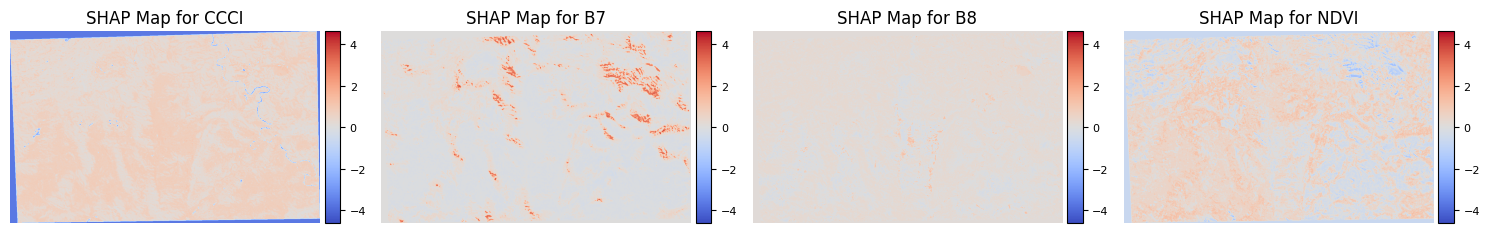

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot SHAP maps
fig, axes = plt.subplots(1, len(Predictors), figsize=(15, 8))  # Increased height for better aspect ratio
if len(Predictors) == 1:
    axes = [axes]  # Ensure axes is iterable

for ax, predictor_name in zip(axes, Predictors):
    shap_map = shap_maps[predictor_name]
    # Mask NaN values
    masked_shap_map = np.ma.masked_invalid(shap_map)
    cmap = plt.cm.coolwarm
    cmap.set_bad(color='white')  # Set color for NaNs

    # Display the SHAP map
    im = ax.imshow(masked_shap_map, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f'SHAP Map for {predictor_name}')
    ax.axis('off')

    # Adjust the aspect ratio of the axes
    ax.set_aspect('equal')  # Ensures that the x and y axes are scaled equally

    # Create a colorbar with adjusted size
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=8)  # Adjusts the fontsize of the colorbar tick labels

plt.tight_layout()
plt.show()

### SHAP maps
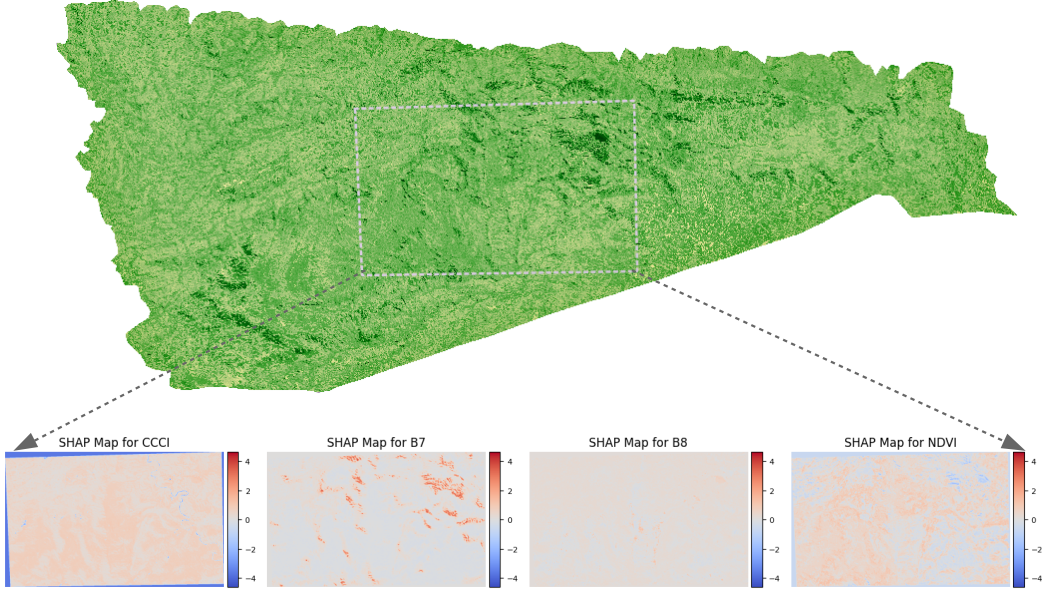